### Importing required libraries

In [1]:
import pandas as pd
import pandas_datareader.data as web
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import yfinance as yf
import warnings
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

warnings.filterwarnings('ignore')

### Collecting data

In [2]:
nifty_smallcap = pd.read_csv('ind_niftysmallcap100list.csv')
nifty_smallcap

,Company Name,Industry,Symbol,Series,ISIN Code
0,Aarti Industries Ltd.,Chemicals,AARTIIND,EQ,INE769A01020
1,Aavas Financiers Ltd.,Financial Services,AAVAS,EQ,INE216P01012
2,Affle (India) Ltd.,Information Technology,AFFLE,EQ,INE00WC01027
3,Alok Industries Ltd.,Textiles,ALOKINDS,EQ,INE270A01029
4,Amara Raja Energy & Mobility Ltd.,Automobile and Auto Components,ARE&M,EQ,INE885A01032
...,...,...,...,...,...
96,Triveni Turbine Ltd.,Capital Goods,TRITURBINE,EQ,INE152M01016
97,UCO Bank,Financial Services,UCOBANK,EQ,INE691A01018
98,Ujjivan Small Finance Bank Ltd.,Financial Services,UJJIVANSFB,EQ,INE551W01018
99,Welspun Living Ltd.,Textiles,WELSPUNLIV,EQ,INE192B01031


In [3]:
# Extracting Symbol column
symbols_list = nifty_smallcap['Symbol'].apply(lambda x: x + '.NS').tolist()

start_date = '2019-01-01'
end_date = '2024-07-01'

df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()
df

[*********************100%%**********************]  101 of 101 completed

1 Failed download:
['DUMMYRAYMD.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


Price                      Adj Close       Close        High         Low  \
Date       Ticker                                                          
2019-01-01 AARTIIND.NS    343.665009  352.001434  353.629517  347.554657   
           AAVAS.NS       845.250000  845.250000  865.000000  840.000000   
           ALOKINDS.NS      4.050000    4.050000    4.050000    4.000000   
           AMBER.NS       906.274902  909.000000  912.000000  902.000000   
           APARINDS.NS    613.632446  665.599976  674.900024  659.650024   
...                              ...         ...         ...         ...   
2024-06-28 TTML.NS         77.730003   77.730003   79.300003   77.519997   
           UCOBANK.NS      54.779999   54.779999   56.080002   54.290001   
           UJJIVANSFB.NS   43.560249   45.049999   45.759998   44.000000   
           WELSPUNLIV.NS  153.660004  153.660004  156.000000  152.449997   
           ZENSARTECH.NS  740.730408  747.349976  750.950012  735.950012   

Price                           Open      Volume  
Date       Ticker                                 
2019-01-01 AARTIIND.NS    352.341644     54503.0  
           AAVAS.NS       851.000000     15420.0  
           ALOKINDS.NS      4.000000   1334718.0  
           AMBER.NS       910.200012       898.0  
           APARINDS.NS    660.450012      2470.0  
...                              ...         ...  
2024-06-28 TTML.NS         78.750000   3802616.0  
           UCOBANK.NS      54.299999   9214823.0  
           UJJIVANSFB.NS   44.400002  39881210.0  
           WELSPUNLIV.NS  153.899994   3887869.0  
           ZENSARTECH.NS  744.700012    522382.0  

[123511 rows x 6 columns]

In [4]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

Price                      adj close       close        high         low  \
date       ticker                                                          
2019-01-01 AARTIIND.NS    343.665009  352.001434  353.629517  347.554657   
           AAVAS.NS       845.250000  845.250000  865.000000  840.000000   
           ALOKINDS.NS      4.050000    4.050000    4.050000    4.000000   
           AMBER.NS       906.274902  909.000000  912.000000  902.000000   
           APARINDS.NS    613.632446  665.599976  674.900024  659.650024   
...                              ...         ...         ...         ...   
2024-06-28 TTML.NS         77.730003   77.730003   79.300003   77.519997   
           UCOBANK.NS      54.779999   54.779999   56.080002   54.290001   
           UJJIVANSFB.NS   43.560249   45.049999   45.759998   44.000000   
           WELSPUNLIV.NS  153.660004  153.660004  156.000000  152.449997   
           ZENSARTECH.NS  740.730408  747.349976  750.950012  735.950012   

Price                           open      volume  
date       ticker                                 
2019-01-01 AARTIIND.NS    352.341644     54503.0  
           AAVAS.NS       851.000000     15420.0  
           ALOKINDS.NS      4.000000   1334718.0  
           AMBER.NS       910.200012       898.0  
           APARINDS.NS    660.450012      2470.0  
...                              ...         ...  
2024-06-28 TTML.NS         78.750000   3802616.0  
           UCOBANK.NS      54.299999   9214823.0  
           UJJIVANSFB.NS   44.400002  39881210.0  
           WELSPUNLIV.NS  153.899994   3887869.0  
           ZENSARTECH.NS  744.700012    522382.0  

[123511 rows x 6 columns]

### Calculating feature and technical indicators

In [5]:
# Calculate Garman-Klass Volatility
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df

Price                      adj close       close        high         low  \
date       ticker                                                          
2019-01-01 AARTIIND.NS    343.665009  352.001434  353.629517  347.554657   
           AAVAS.NS       845.250000  845.250000  865.000000  840.000000   
           ALOKINDS.NS      4.050000    4.050000    4.050000    4.000000   
           AMBER.NS       906.274902  909.000000  912.000000  902.000000   
           APARINDS.NS    613.632446  665.599976  674.900024  659.650024   
...                              ...         ...         ...         ...   
2024-06-28 TTML.NS         77.730003   77.730003   79.300003   77.519997   
           UCOBANK.NS      54.779999   54.779999   56.080002   54.290001   
           UJJIVANSFB.NS   43.560249   45.049999   45.759998   44.000000   
           WELSPUNLIV.NS  153.660004  153.660004  156.000000  152.449997   
           ZENSARTECH.NS  740.730408  747.349976  750.950012  735.950012   

Price                           open      volume  garman_klass_vol  
date       ticker                                                   
2019-01-01 AARTIIND.NS    352.341644     54503.0         -0.000090  
           AAVAS.NS       851.000000     15420.0          0.000412  
           ALOKINDS.NS      4.000000   1334718.0          0.000018  
           AMBER.NS       910.200012       898.0          0.000054  
           APARINDS.NS    660.450012      2470.0         -0.001827  
...                              ...         ...               ...  
2024-06-28 TTML.NS         78.750000   3802616.0          0.000192  
           UCOBANK.NS      54.299999   9214823.0          0.000496  
           UJJIVANSFB.NS   44.400002  39881210.0          0.000628  
           WELSPUNLIV.NS  153.899994   3887869.0          0.000264  
           ZENSARTECH.NS  744.700012    522382.0          0.000193  

[123511 rows x 7 columns]

In [6]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.rsi(close=x, length=20))
df

Price                      adj close       close        high         low  \
date       ticker                                                          
2019-01-01 AARTIIND.NS    343.665009  352.001434  353.629517  347.554657   
           AAVAS.NS       845.250000  845.250000  865.000000  840.000000   
           ALOKINDS.NS      4.050000    4.050000    4.050000    4.000000   
           AMBER.NS       906.274902  909.000000  912.000000  902.000000   
           APARINDS.NS    613.632446  665.599976  674.900024  659.650024   
...                              ...         ...         ...         ...   
2024-06-28 TTML.NS         77.730003   77.730003   79.300003   77.519997   
           UCOBANK.NS      54.779999   54.779999   56.080002   54.290001   
           UJJIVANSFB.NS   43.560249   45.049999   45.759998   44.000000   
           WELSPUNLIV.NS  153.660004  153.660004  156.000000  152.449997   
           ZENSARTECH.NS  740.730408  747.349976  750.950012  735.950012   

Price                           open      volume  garman_klass_vol        rsi  
date       ticker                                                              
2019-01-01 AARTIIND.NS    352.341644     54503.0         -0.000090        NaN  
           AAVAS.NS       851.000000     15420.0          0.000412        NaN  
           ALOKINDS.NS      4.000000   1334718.0          0.000018        NaN  
           AMBER.NS       910.200012       898.0          0.000054        NaN  
           APARINDS.NS    660.450012      2470.0         -0.001827        NaN  
...                              ...         ...               ...        ...  
2024-06-28 TTML.NS         78.750000   3802616.0          0.000192  49.928570  
           UCOBANK.NS      54.299999   9214823.0          0.000496  47.842133  
           UJJIVANSFB.NS   44.400002  39881210.0          0.000628  37.566956  
           WELSPUNLIV.NS  153.899994   3887869.0          0.000264  60.254214  
           ZENSARTECH.NS  744.700012    522382.0          0.000193  67.934303  

[123511 rows x 8 columns]

<Axes: xlabel='date'>

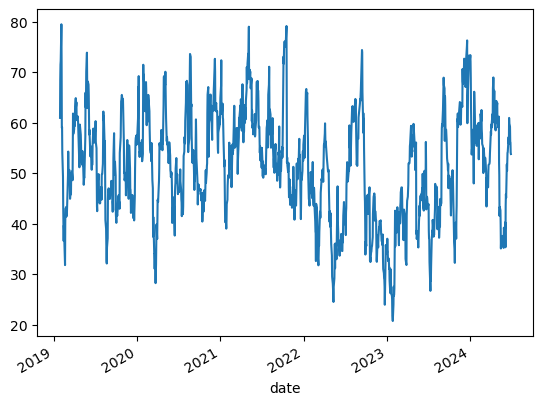

In [7]:
df.xs('AARTIIND.NS', level=1)['rsi'].plot()

In [8]:
ta.bbands(close=df.xs('AARTIIND.NS', level=1)['adj close'], lenght=20)

,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0
date,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN
2019-01-02,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN
2019-01-07,337.754660,344.642438,351.530216,3.997057,0.828594
...,...,...,...,...,...
2024-06-24,678.226847,699.486108,720.745370,6.078537,0.627994
2024-06-25,680.681355,700.434729,720.188103,5.640318,0.342028
2024-06-26,687.913043,702.282056,716.651068,4.092092,0.195967


In [9]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: ta.bbands(close=np.log1p(x), length=20).iloc[:,2])
df

Price                      adj close       close        high         low  \
date       ticker                                                          
2019-01-01 AARTIIND.NS    343.665009  352.001434  353.629517  347.554657   
           AAVAS.NS       845.250000  845.250000  865.000000  840.000000   
           ALOKINDS.NS      4.050000    4.050000    4.050000    4.000000   
           AMBER.NS       906.274902  909.000000  912.000000  902.000000   
           APARINDS.NS    613.632446  665.599976  674.900024  659.650024   
...                              ...         ...         ...         ...   
2024-06-28 TTML.NS         77.730003   77.730003   79.300003   77.519997   
           UCOBANK.NS      54.779999   54.779999   56.080002   54.290001   
           UJJIVANSFB.NS   43.560249   45.049999   45.759998   44.000000   
           WELSPUNLIV.NS  153.660004  153.660004  156.000000  152.449997   
           ZENSARTECH.NS  740.730408  747.349976  750.950012  735.950012   

Price                           open      volume  garman_klass_vol        rsi  \
date       ticker                                                               
2019-01-01 AARTIIND.NS    352.341644     54503.0         -0.000090        NaN   
           AAVAS.NS       851.000000     15420.0          0.000412        NaN   
           ALOKINDS.NS      4.000000   1334718.0          0.000018        NaN   
           AMBER.NS       910.200012       898.0          0.000054        NaN   
           APARINDS.NS    660.450012      2470.0         -0.001827        NaN   
...                              ...         ...               ...        ...   
2024-06-28 TTML.NS         78.750000   3802616.0          0.000192  49.928570   
           UCOBANK.NS      54.299999   9214823.0          0.000496  47.842133   
           UJJIVANSFB.NS   44.400002  39881210.0          0.000628  37.566956   
           WELSPUNLIV.NS  153.899994   3887869.0          0.000264  60.254214   
           ZENSARTECH.NS  744.700012    522382.0          0.000193  67.934303   

Price                       bb_low    bb_mid   bb_high  
date       ticker                                       
2019-01-01 AARTIIND.NS         NaN       NaN       NaN  
           AAVAS.NS            NaN       NaN       NaN  
           ALOKINDS.NS         NaN       NaN       NaN  
           AMBER.NS            NaN       NaN       NaN  
           APARINDS.NS         NaN       NaN       NaN  
...                            ...       ...       ...  
2024-06-28 TTML.NS        4.273647  4.353118  4.432589  
           UCOBANK.NS     3.992229  4.048132  4.104035  
           UJJIVANSFB.NS  3.765182  3.858228  3.951274  
           WELSPUNLIV.NS  4.865016  4.959966  5.054916  
           ZENSARTECH.NS  6.368633  6.530409  6.692185  

[123511 rows x 11 columns]

In [10]:
def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['rupee_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                      adj close       close        high         low  \
date       ticker                                                          
2019-01-01 AARTIIND.NS    343.665009  352.001434  353.629517  347.554657   
           AAVAS.NS       845.250000  845.250000  865.000000  840.000000   
           ALOKINDS.NS      4.050000    4.050000    4.050000    4.000000   
           AMBER.NS       906.274902  909.000000  912.000000  902.000000   
           APARINDS.NS    613.632446  665.599976  674.900024  659.650024   
...                              ...         ...         ...         ...   
2024-06-28 TTML.NS         77.730003   77.730003   79.300003   77.519997   
           UCOBANK.NS      54.779999   54.779999   56.080002   54.290001   
           UJJIVANSFB.NS   43.560249   45.049999   45.759998   44.000000   
           WELSPUNLIV.NS  153.660004  153.660004  156.000000  152.449997   
           ZENSARTECH.NS  740.730408  747.349976  750.950012  735.950012   

Price                           open      volume  garman_klass_vol        rsi  \
date       ticker                                                               
2019-01-01 AARTIIND.NS    352.341644     54503.0         -0.000090        NaN   
           AAVAS.NS       851.000000     15420.0          0.000412        NaN   
           ALOKINDS.NS      4.000000   1334718.0          0.000018        NaN   
           AMBER.NS       910.200012       898.0          0.000054        NaN   
           APARINDS.NS    660.450012      2470.0         -0.001827        NaN   
...                              ...         ...               ...        ...   
2024-06-28 TTML.NS         78.750000   3802616.0          0.000192  49.928570   
           UCOBANK.NS      54.299999   9214823.0          0.000496  47.842133   
           UJJIVANSFB.NS   44.400002  39881210.0          0.000628  37.566956   
           WELSPUNLIV.NS  153.899994   3887869.0          0.000264  60.254214   
           ZENSARTECH.NS  744.700012    522382.0          0.000193  67.934303   

Price                       bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                            
2019-01-01 AARTIIND.NS         NaN       NaN       NaN       NaN       NaN   
           AAVAS.NS            NaN       NaN       NaN       NaN       NaN   
           ALOKINDS.NS         NaN       NaN       NaN       NaN       NaN   
           AMBER.NS            NaN       NaN       NaN       NaN       NaN   
           APARINDS.NS         NaN       NaN       NaN       NaN       NaN   
...                            ...       ...       ...       ...       ...   
2024-06-28 TTML.NS        4.273647  4.353118  4.432589  0.068281  0.016458   
           UCOBANK.NS     3.992229  4.048132  4.104035  1.716212 -0.380908   
           UJJIVANSFB.NS  3.765182  3.858228  3.951274  0.952181 -1.362404   
           WELSPUNLIV.NS  4.865016  4.959966  5.054916  0.755004  0.630352   
           ZENSARTECH.NS  6.368633  6.530409  6.692185  2.208631  3.140575   

Price                     rupee_volume  
date       ticker                       
2019-01-01 AARTIIND.NS       18.730774  
           AAVAS.NS          13.033755  
           ALOKINDS.NS        5.405608  
           AMBER.NS           0.813835  
           APARINDS.NS        1.515672  
...                                ...  
2024-06-28 TTML.NS          295.577354  
           UCOBANK.NS       504.787993  
           UJJIVANSFB.NS   1737.235451  
           WELSPUNLIV.NS    597.409965  
           ZENSARTECH.NS    386.944232  

[123511 rows x 14 columns]

### Finding top 200 most liquid stocks

In [11]:
last_cols = [c for c in df.columns.unique(0) if c not in ['rupee_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['rupee_volume'].resample('M').mean().stack('ticker').to_frame('rupee_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

rupee_volume    adj close       atr   bb_high  \
date       ticker                                                       
2019-02-28 AARTIIND.NS    234.734093   330.669189 -0.654415  6.028891   
           AAVAS.NS        62.251321  1004.150024 -1.512651  6.940814   
           ALOKINDS.NS      7.441262     3.400000 -1.256122  1.576855   
           AMBER.NS        21.359216   672.627502 -1.297129  6.599545   
           APARINDS.NS      3.077128   582.287048 -0.668665  6.380265   
...                              ...          ...       ...       ...   
2024-06-30 FIVESTAR.NS    461.181960   793.250000  0.696735  6.736832   
           NSLNISP.NS     505.817093    56.700001 -0.091993  4.142233   
           RRKABEL.NS     254.963982  1737.393799  0.126756  7.509195   
           ARE&M.NS      7761.812133  1657.746582  2.680105  7.449865   
           HONASA.NS      566.259552   432.850006 -0.235172  6.143267   

                          bb_low    bb_mid  garman_klass_vol      macd  \
date       ticker                                                        
2019-02-28 AARTIIND.NS  5.701969  5.865430          0.000726 -0.682028   
           AAVAS.NS     6.677170  6.808992          0.000219  0.687510   
           ALOKINDS.NS  1.422001  1.499428          0.000997 -0.183693   
           AMBER.NS     6.431969  6.515757          0.000314 -0.849810   
           APARINDS.NS  6.319077  6.349671         -0.002889 -0.503045   
...                          ...       ...               ...       ...   
2024-06-30 FIVESTAR.NS  6.609943  6.673387          0.000166  0.819977   
           NSLNISP.NS   4.035044  4.088639          0.000251 -1.122822   
           RRKABEL.NS   7.398894  7.454044          0.000169 -0.026423   
           ARE&M.NS     6.998635  7.224250          0.002844  2.928660   
           HONASA.NS    6.034054  6.088661          0.002702 -0.002675   

                              rsi  
date       ticker                  
2019-02-28 AARTIIND.NS  41.672384  
           AAVAS.NS     77.200283  
           ALOKINDS.NS  43.708578  
           AMBER.NS     31.628105  
           APARINDS.NS  52.112285  
...                           ...  
2024-06-30 FIVESTAR.NS  55.451590  
           NSLNISP.NS   41.741993  
           RRKABEL.NS   53.746151  
           ARE&M.NS     72.725855  
           HONASA.NS    50.272231  

[5925 rows x 9 columns]

In [12]:
data['rupee_volume'] = (data.loc[:, 'rupee_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['rupee_vol_rank'] = (data.groupby('date')['rupee_volume'].rank(ascending=False))

data = data[data['rupee_vol_rank']<200].drop(['rupee_volume', 'rupee_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                              
2020-01-31 AARTIIND.NS    484.421753 -0.416142  6.175103  5.978949  6.077026   
           AAVAS.NS      1994.050049 -0.301559  7.616171  7.562215  7.589193   
           ALOKINDS.NS      3.300000 -1.365175  1.479192  1.289894  1.384543   
           AMBER.NS      1508.333130 -0.667283  7.353572  7.017855  7.185714   
           APARINDS.NS    365.391205 -0.652899  6.049550  5.871775  5.960663   
...                              ...       ...       ...       ...       ...   
2024-06-30 PPLPHARMA.NS   157.125916  0.384117  5.095726  4.984358  5.040042   
           PVRINOX.NS    1427.349976 -0.369114  7.304796  7.156688  7.230742   
           MEDANTA.NS    1308.300049  1.138267  7.262292  7.008793  7.135542   
           FIVESTAR.NS    793.250000  0.696735  6.736832  6.609943  6.673387   
           NSLNISP.NS      56.700001 -0.091993  4.142233  4.035044  4.088639   

                         garman_klass_vol      macd        rsi  
date       ticker                                               
2020-01-31 AARTIIND.NS           0.001093  0.901467  69.511196  
           AAVAS.NS              0.000308  0.275784  56.766892  
           ALOKINDS.NS           0.000000 -0.011400  62.410357  
           AMBER.NS              0.002883  1.204277  80.689171  
           APARINDS.NS          -0.001126 -0.574558  38.557151  
...                                   ...       ...        ...  
2024-06-30 PPLPHARMA.NS          0.000189  0.663669  57.846261  
           PVRINOX.NS            0.000348  1.209276  57.164772  
           MEDANTA.NS            0.000504 -0.345588  51.580797  
           FIVESTAR.NS           0.000166  0.819977  55.451590  
           NSLNISP.NS            0.000251 -1.122822  41.741993  

[4834 rows x 8 columns]

## Monthly returns

In [13]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                               
2021-01-31 AARTIIND.NS     572.747742  0.045152  6.514420  6.313039  6.413729   
           AAVAS.NS       1807.750000  0.391175  7.620543  7.470624  7.545583   
           ALOKINDS.NS      21.250000  0.203578  3.230029  3.084354  3.157192   
           AMBER.NS       2579.750000  0.168081  7.906866  7.775565  7.841215   
           APARINDS.NS     350.432587 -0.625835  5.946608  5.792510  5.869559   
...                               ...       ...       ...       ...       ...   
2024-06-30 ANGELONE.NS    2602.000000  0.547093  7.930718  7.767973  7.849345   
           CAMS.NS        3596.918457  1.773053  8.226800  8.106526  8.166663   
           EQUITASBNK.NS    97.160004  1.059760  4.693833  4.520118  4.606975   
           SHYAMMETL.NS    669.400024  1.781169  6.570991  6.350109  6.460550   
           DATAPATTNS.NS  2995.289551  2.002860  8.077050  7.823770  7.950410   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2021-01-31 AARTIIND.NS            0.000960 -0.717076  43.856609  -0.061184   
           AAVAS.NS               0.000358  0.435385  51.441884   0.066173   
           ALOKINDS.NS            0.000370 -0.401110  42.512618  -0.087983   
           AMBER.NS               0.000206  0.366581  57.928425   0.096460   
           APARINDS.NS            0.007596 -0.493770  52.044670   0.042120   
...                                    ...       ...        ...        ...   
2024-06-30 ANGELONE.NS            0.000266 -0.358766  49.181433   0.054594   
           CAMS.NS                0.000390  0.969071  56.226914   0.038117   
           EQUITASBNK.NS          0.000628  0.571675  47.634668   0.049244   
           SHYAMMETL.NS           0.000505  1.022606  57.201943   0.097827   
           DATAPATTNS.NS          0.000166  0.404261  55.207574   0.013165   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2021-01-31 AARTIIND.NS     0.001708   0.050757   0.026977   0.005860   
           AAVAS.NS        0.060393   0.080917   0.047239   0.047751   
           ALOKINDS.NS    -0.016075  -0.009238  -0.078922   0.126915   
           AMBER.NS        0.036858   0.057663   0.096724   0.102499   
           APARINDS.NS     0.020843   0.081459   0.031270   0.017273   
...                             ...        ...        ...        ...   
2024-06-30 ANGELONE.NS    -0.033690  -0.051057  -0.046206   0.039695   
           CAMS.NS         0.062089   0.074074   0.053642   0.042156   
           EQUITASBNK.NS   0.000567   0.016335  -0.013632   0.008979   
           SHYAMMETL.NS    0.031574   0.042190   0.010751   0.047357   
           DATAPATTNS.NS   0.005281   0.074113   0.082900   0.040414   

                          return_12m  
date       ticker                     
2021-01-31 AARTIIND.NS      0.014055  
           AAVAS.NS        -0.008140  
           ALOKINDS.NS      0.163666  
           AMBER.NS         0.045739  
           APARINDS.NS      0.003029  
...                              ...  
2024-06-30 ANGELONE.NS      0.036497  
           CAMS.NS          0.043687  
           EQUITASBNK.NS    0.008026  
           SHYAMMETL.NS     0.053330  
           DATAPATTNS.NS    0.040494  

[3692 rows x 14 columns]

## Fama-French factors and rolling factor betas

In [14]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2018')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2021-01-31 AARTIIND.NS   -0.0003  0.0694  0.0304 -0.0379  0.0492  -0.061184
           AAVAS.NS      -0.0003  0.0694  0.0304 -0.0379  0.0492   0.066173
           ALOKINDS.NS   -0.0003  0.0694  0.0304 -0.0379  0.0492  -0.087983
           AMBER.NS      -0.0003  0.0694  0.0304 -0.0379  0.0492   0.096460
           APARINDS.NS   -0.0003  0.0694  0.0304 -0.0379  0.0492   0.042120
...                          ...     ...     ...     ...     ...        ...
2024-06-30 TTML.NS        0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.041957
           UCOBANK.NS     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.038104
           UJJIVANSFB.NS  0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.094472
           WELSPUNLIV.NS  0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.127730
           ZENSARTECH.NS  0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.224963

[3692 rows x 6 columns]

In [15]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2021-01-31 AARTIIND.NS   -0.0003  0.0694  0.0304 -0.0379  0.0492  -0.061184
           AAVAS.NS      -0.0003  0.0694  0.0304 -0.0379  0.0492   0.066173
           ALOKINDS.NS   -0.0003  0.0694  0.0304 -0.0379  0.0492  -0.087983
           AMBER.NS      -0.0003  0.0694  0.0304 -0.0379  0.0492   0.096460
           APARINDS.NS   -0.0003  0.0694  0.0304 -0.0379  0.0492   0.042120
...                          ...     ...     ...     ...     ...        ...
2024-06-30 TTML.NS        0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.041957
           UCOBANK.NS     0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.038104
           UJJIVANSFB.NS  0.0278 -0.0433 -0.0331  0.0049 -0.0182  -0.094472
           WELSPUNLIV.NS  0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.127730
           ZENSARTECH.NS  0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.224963

[3685 rows x 6 columns]

## Rolling factor betas

In [16]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2021-01-31 AARTIIND.NS         NaN       NaN       NaN       NaN       NaN
           AAVAS.NS            NaN       NaN       NaN       NaN       NaN
           ALOKINDS.NS         NaN       NaN       NaN       NaN       NaN
           AMBER.NS            NaN       NaN       NaN       NaN       NaN
           APARINDS.NS         NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2024-06-30 TTML.NS        0.338866 -1.688269  1.129677 -0.773664 -0.346409
           UCOBANK.NS    -0.434853  1.136504 -2.045353  1.672439  4.483903
           UJJIVANSFB.NS -0.187394  1.180892 -0.122578  0.370524 -0.560975
           WELSPUNLIV.NS  0.092669 -2.017440  0.799855 -0.430509  0.262484
           ZENSARTECH.NS  0.178202  0.648552  0.657935 -0.209893 -1.142896

[3685 rows x 5 columns]

In [17]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data = data.drop('adj close', axis=1)

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data

atr   bb_high    bb_low    bb_mid  \
date       ticker                                                  
2021-01-31 AARTIIND.NS    0.045152  6.514420  6.313039  6.413729   
           AAVAS.NS       0.391175  7.620543  7.470624  7.545583   
           ALOKINDS.NS    0.203578  3.230029  3.084354  3.157192   
           AMBER.NS       0.168081  7.906866  7.775565  7.841215   
           APARINDS.NS   -0.625835  5.946608  5.792510  5.869559   
...                            ...       ...       ...       ...   
2024-06-30 WELSPUNLIV.NS  0.755004  5.054916  4.865016  4.959966   
           ZENSARTECH.NS  2.208631  6.692185  6.368633  6.530409   
           INDIAMART.NS  -0.504067  7.927870  7.775696  7.851783   
           AFFLE.NS       1.438798  7.242509  6.994187  7.118348   
           UJJIVANSFB.NS  0.952181  3.951274  3.765182  3.858228   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2021-01-31 AARTIIND.NS            0.000960 -0.717076  43.856609  -0.061184   
           AAVAS.NS               0.000358  0.435385  51.441884   0.066173   
           ALOKINDS.NS            0.000370 -0.401110  42.512618  -0.087983   
           AMBER.NS               0.000206  0.366581  57.928425   0.096460   
           APARINDS.NS            0.007596 -0.493770  52.044670   0.042120   
...                                    ...       ...        ...        ...   
2024-06-30 WELSPUNLIV.NS          0.000264  0.630352  60.254214   0.127730   
           ZENSARTECH.NS          0.000193  3.140575  67.934303   0.224963   
           INDIAMART.NS           0.000109  0.279479  58.032368   0.117621   
           AFFLE.NS               0.000472  1.625558  64.031130   0.181534   
           UJJIVANSFB.NS          0.000628 -1.362404  37.566956  -0.094472   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2021-01-31 AARTIIND.NS     0.001708   0.050757   0.026977   0.005860   
           AAVAS.NS        0.060393   0.080917   0.047239   0.047751   
           ALOKINDS.NS    -0.016075  -0.009238  -0.078922   0.126915   
           AMBER.NS        0.036858   0.057663   0.096724   0.102499   
           APARINDS.NS     0.020843   0.081459   0.031270   0.017273   
...                             ...        ...        ...        ...   
2024-06-30 WELSPUNLIV.NS   0.012813   0.037721   0.010471   0.026561   
           ZENSARTECH.NS   0.103934   0.071942   0.034851   0.042113   
           INDIAMART.NS    0.010941   0.007084  -0.001218  -0.006919   
           AFFLE.NS        0.095323   0.088562   0.004741   0.021774   
           UJJIVANSFB.NS  -0.083648   0.005612  -0.038173  -0.020135   

                          return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                              
2021-01-31 AARTIIND.NS      0.014055  0.600255 -1.015023  0.245571 -0.649940   
           AAVAS.NS        -0.008140  0.261668 -0.192970  1.448099 -0.328052   
           ALOKINDS.NS      0.163666  0.054669 -1.972062  0.336513 -0.181058   
           AMBER.NS         0.045739  0.123892 -1.229454  0.736826 -0.668290   
           APARINDS.NS      0.003029 -0.317904  1.345239 -0.419586  1.557265   
...                              ...       ...       ...       ...       ...   
2024-06-30 WELSPUNLIV.NS    0.043309 -0.162711 -1.397188  0.455217  0.013589   
           ZENSARTECH.NS    0.057367  0.314909  0.550160  1.097509 -0.376055   
           INDIAMART.NS    -0.003383  0.493889  0.262152 -0.369502 -0.836073   
           AFFLE.NS         0.017102  0.036511  0.735018  0.118291 -0.502605   
           UJJIVANSFB.NS    0.015530  0.266308  0.029915  0.436142 -0.433476   

                               CMA  
date       ticker                   
2021-01-31 AARTIIND.NS   -0.292861  
           AAVAS.NS      -2.149920  
     

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3588 entries, (Timestamp('2021-01-31 00:00:00'), 'AARTIIND.NS') to (Timestamp('2024-06-30 00:00:00'), 'UJJIVANSFB.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               3588 non-null   float64
 1   bb_high           3588 non-null   float64
 2   bb_low            3588 non-null   float64
 3   bb_mid            3588 non-null   float64
 4   garman_klass_vol  3588 non-null   float64
 5   macd              3588 non-null   float64
 6   rsi               3588 non-null   float64
 7   return_1m         3588 non-null   float64
 8   return_2m         3588 non-null   float64
 9   return_3m         3588 non-null   float64
 10  return_6m         3588 non-null   float64
 11  return_9m         3588 non-null   float64
 12  return_12m        3588 non-null   float64
 13  Mkt-RF            3588 non-null   float64
 14  SMB               3588 non-null   float64

## Machine Learning model

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [21]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  \
date       ticker                                                  
2021-01-31 AARTIIND.NS    0.045152  6.514420  6.313039  6.413729   
           AAVAS.NS       0.391175  7.620543  7.470624  7.545583   
           ALOKINDS.NS    0.203578  3.230029  3.084354  3.157192   
           AMBER.NS       0.168081  7.906866  7.775565  7.841215   
           APARINDS.NS   -0.625835  5.946608  5.792510  5.869559   
...                            ...       ...       ...       ...   
2024-06-30 WELSPUNLIV.NS  0.755004  5.054916  4.865016  4.959966   
           ZENSARTECH.NS  2.208631  6.692185  6.368633  6.530409   
           INDIAMART.NS  -0.504067  7.927870  7.775696  7.851783   
           AFFLE.NS       1.438798  7.242509  6.994187  7.118348   
           UJJIVANSFB.NS  0.952181  3.951274  3.765182  3.858228   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2021-01-31 AARTIIND.NS            0.000960 -0.717076  43.856609  -0.061184   
           AAVAS.NS               0.000358  0.435385  51.441884   0.066173   
           ALOKINDS.NS            0.000370 -0.401110  42.512618  -0.087983   
           AMBER.NS               0.000206  0.366581  57.928425   0.096460   
           APARINDS.NS            0.007596 -0.493770  52.044670   0.042120   
...                                    ...       ...        ...        ...   
2024-06-30 WELSPUNLIV.NS          0.000264  0.630352  60.254214   0.127730   
           ZENSARTECH.NS          0.000193  3.140575  67.934303   0.224963   
           INDIAMART.NS           0.000109  0.279479  58.032368   0.117621   
           AFFLE.NS               0.000472  1.625558  64.031130   0.181534   
           UJJIVANSFB.NS          0.000628 -1.362404  37.566956  -0.094472   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2021-01-31 AARTIIND.NS     0.001708   0.050757   0.026977   0.005860   
           AAVAS.NS        0.060393   0.080917   0.047239   0.047751   
           ALOKINDS.NS    -0.016075  -0.009238  -0.078922   0.126915   
           AMBER.NS        0.036858   0.057663   0.096724   0.102499   
           APARINDS.NS     0.020843   0.081459   0.031270   0.017273   
...                             ...        ...        ...        ...   
2024-06-30 WELSPUNLIV.NS   0.012813   0.037721   0.010471   0.026561   
           ZENSARTECH.NS   0.103934   0.071942   0.034851   0.042113   
           INDIAMART.NS    0.010941   0.007084  -0.001218  -0.006919   
           AFFLE.NS        0.095323   0.088562   0.004741   0.021774   
           UJJIVANSFB.NS  -0.083648   0.005612  -0.038173  -0.020135   

                          return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                              
2021-01-31 AARTIIND.NS      0.014055  0.600255 -1.015023  0.245571 -0.649940   
           AAVAS.NS        -0.008140  0.261668 -0.192970  1.448099 -0.328052   
           ALOKINDS.NS      0.163666  0.054669 -1.972062  0.336513 -0.181058   
           AMBER.NS         0.045739  0.123892 -1.229454  0.736826 -0.668290   
           APARINDS.NS      0.003029 -0.317904  1.345239 -0.419586  1.557265   
...                              ...       ...       ...       ...       ...   
2024-06-30 WELSPUNLIV.NS    0.043309 -0.162711 -1.397188  0.455217  0.013589   
           ZENSARTECH.NS    0.057367  0.314909  0.550160  1.097509 -0.376055   
           INDIAMART.NS    -0.003383  0.493889  0.262152 -0.369502 -0.836073   
           AFFLE.NS         0.017102  0.036511  0.735018  0.118291 -0.502605   
           UJJIVANSFB.NS    0.015530  0.266308  0.029915  0.436142 -0.433476   

                               CMA  cluster  
date       ticker                            
2021-01-31 AARTIIND.NS   -0.292861        1  
           AAVA

In [22]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

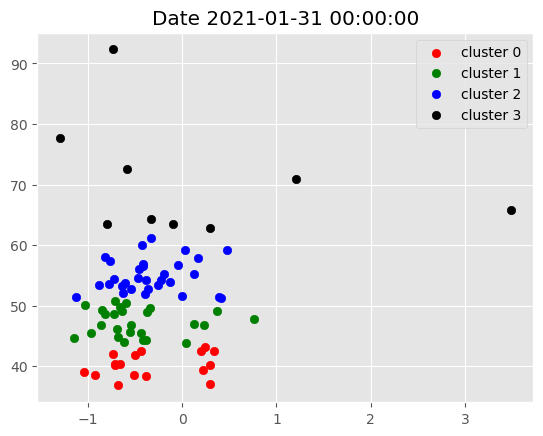

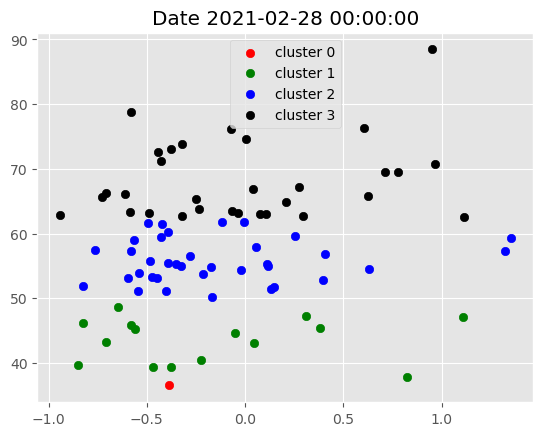

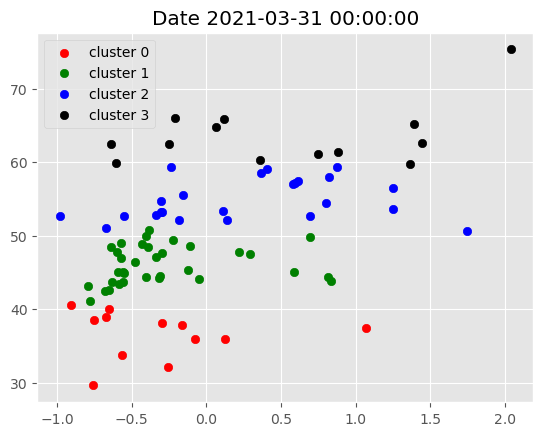

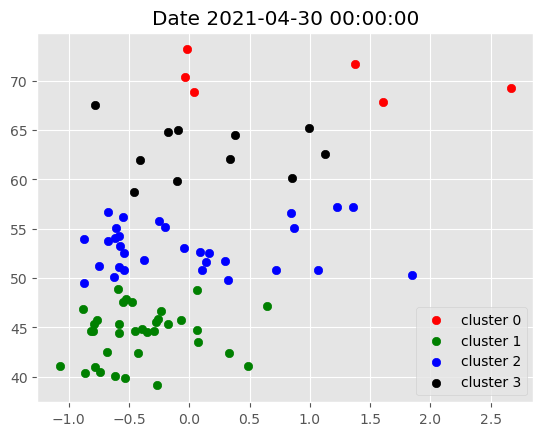

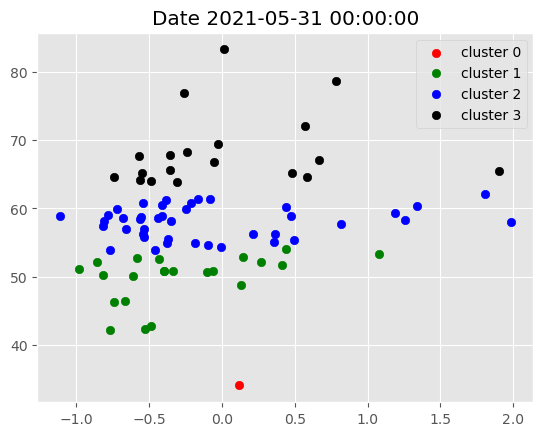

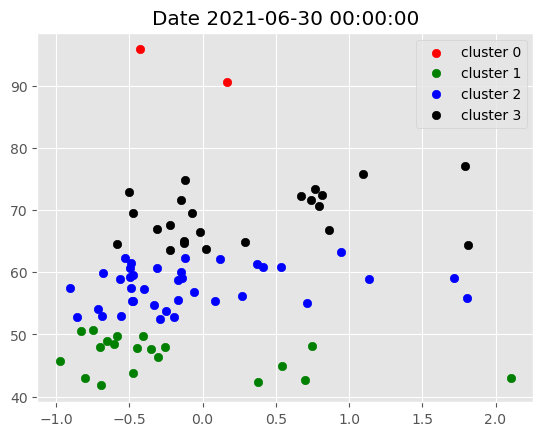

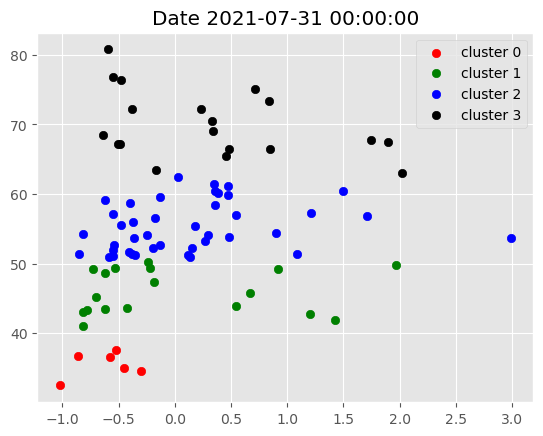

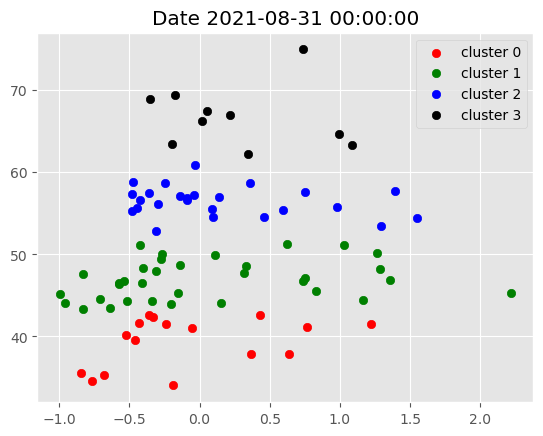

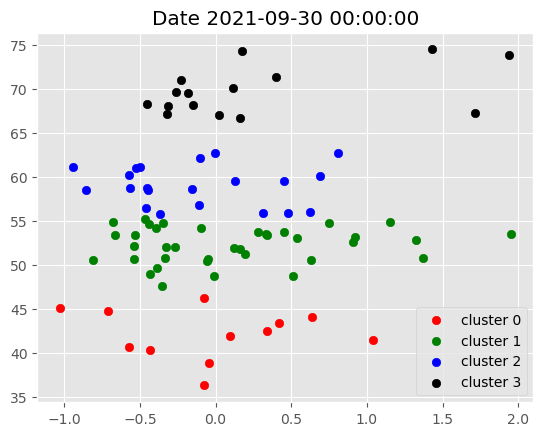

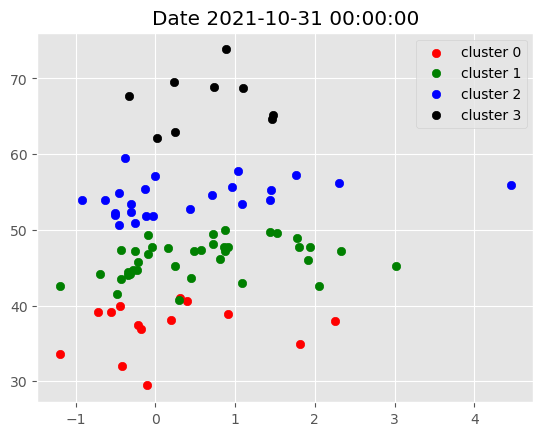

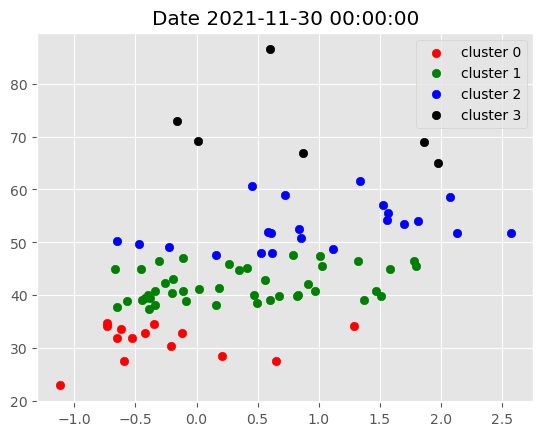

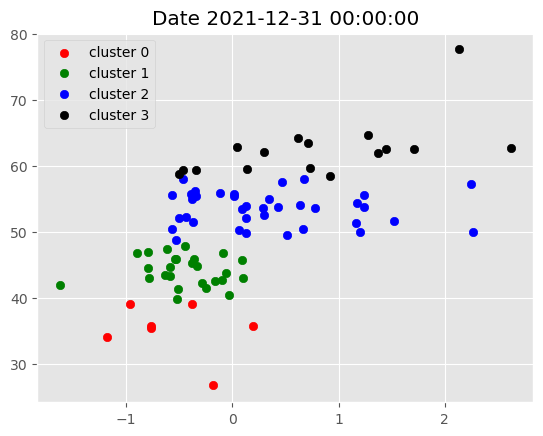

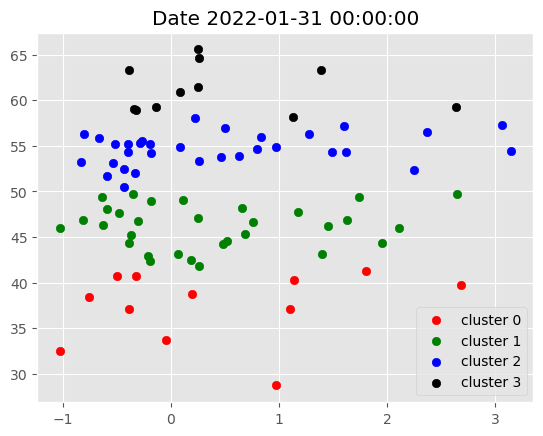

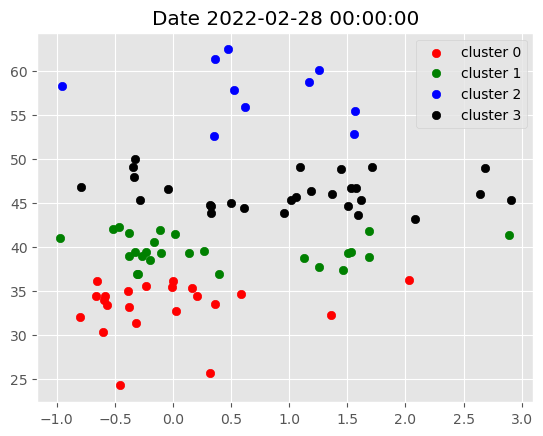

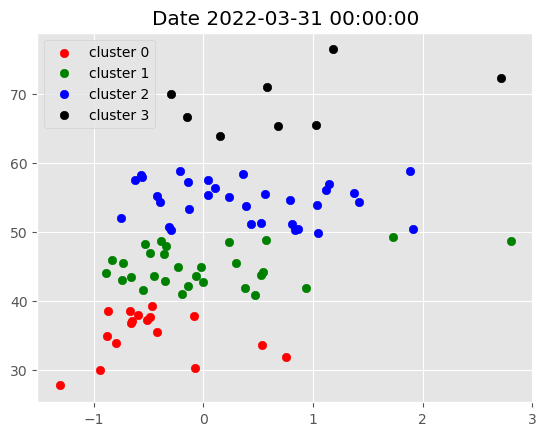

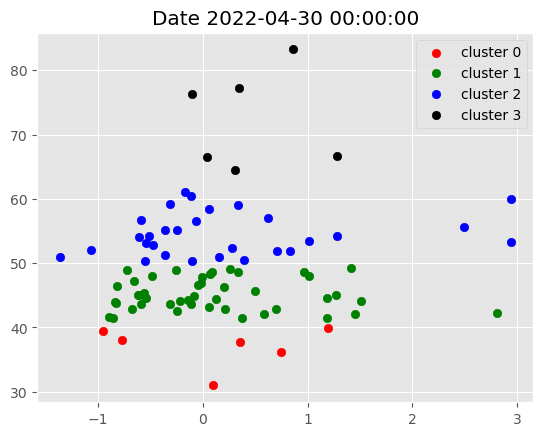

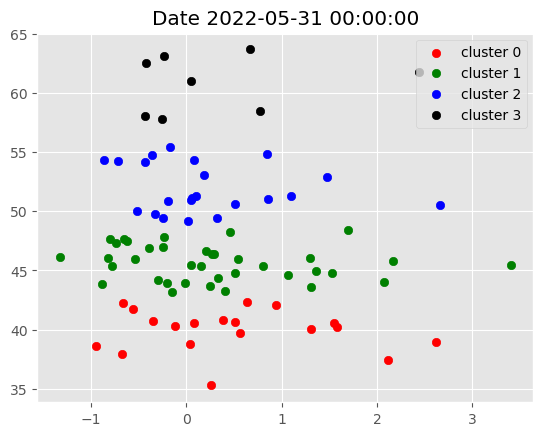

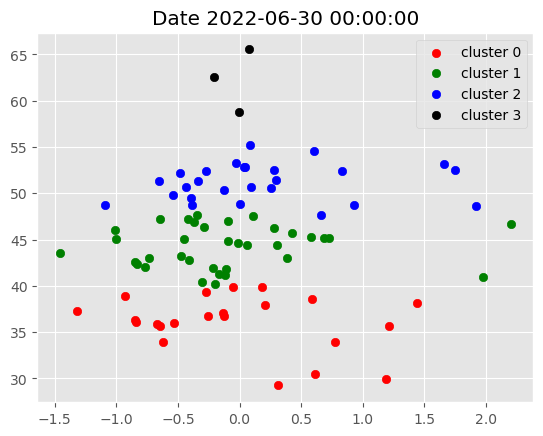

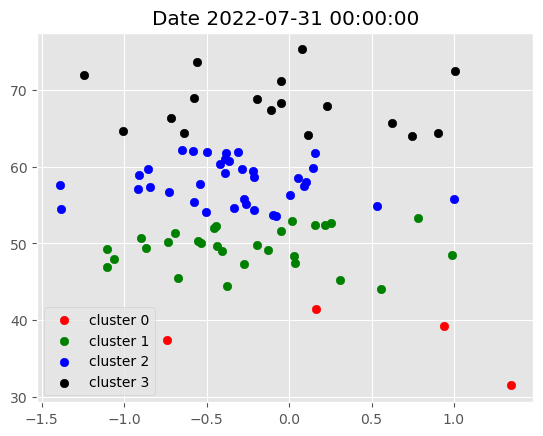

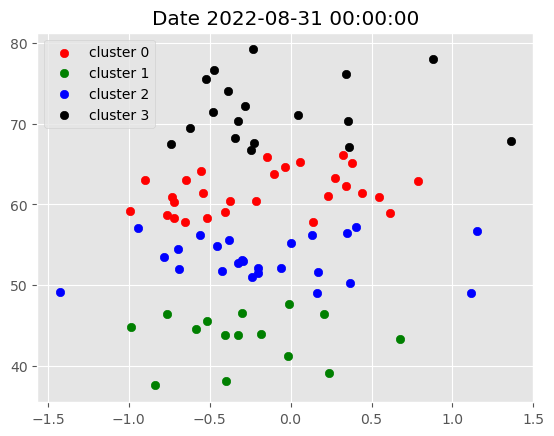

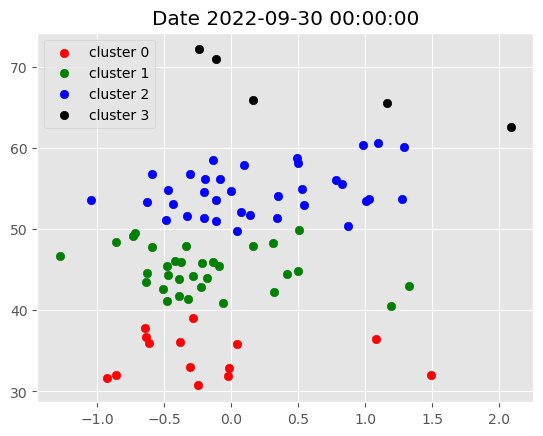

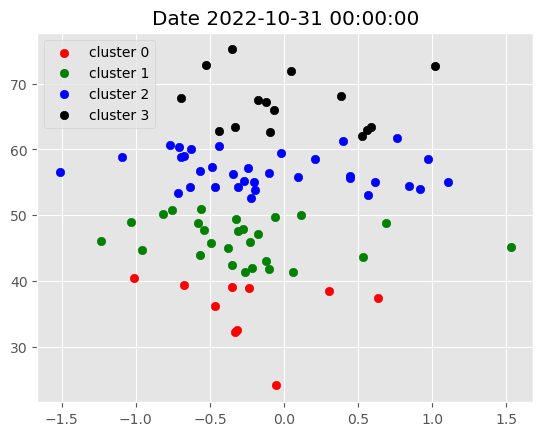

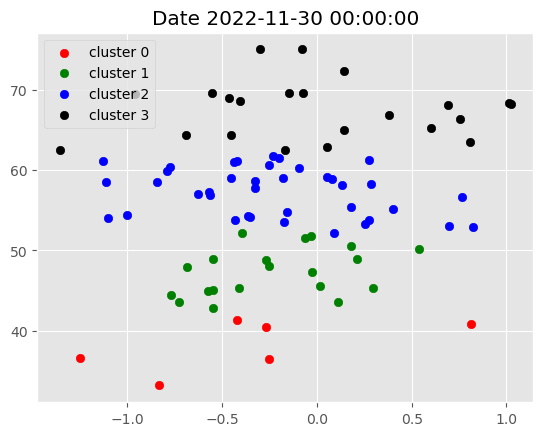

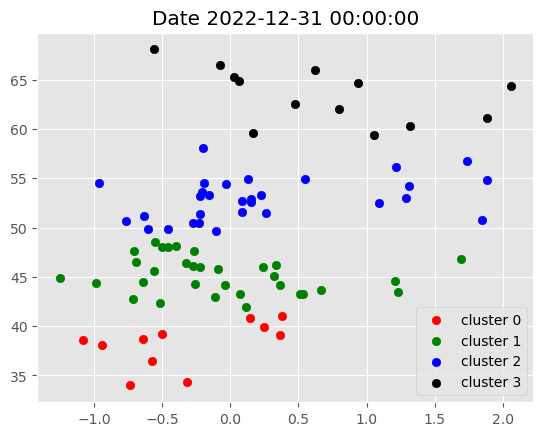

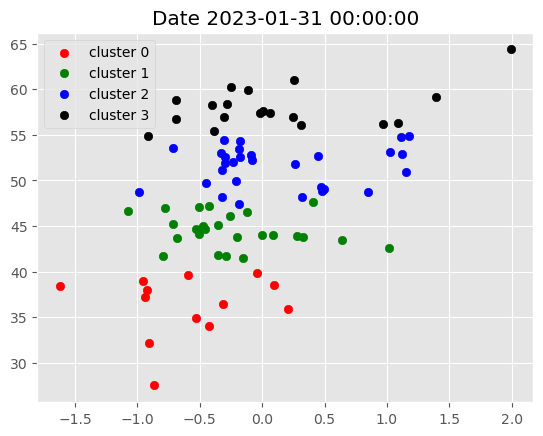

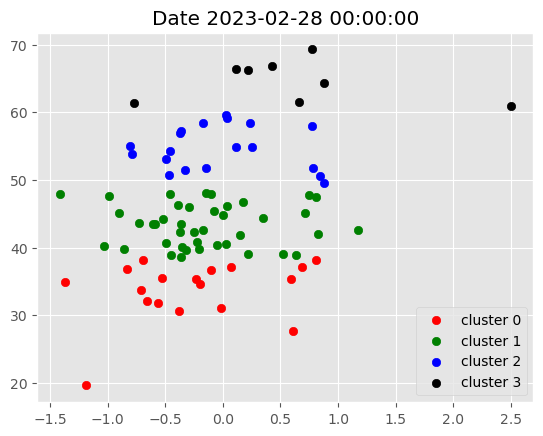

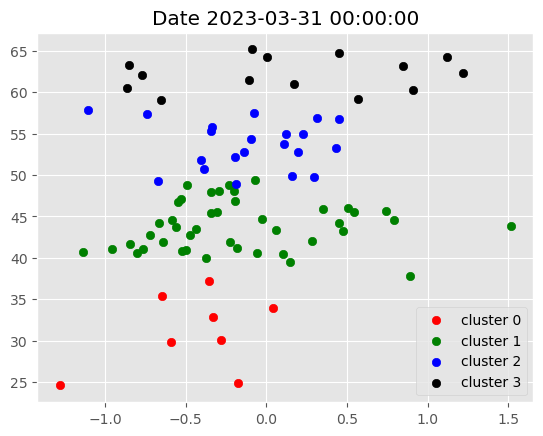

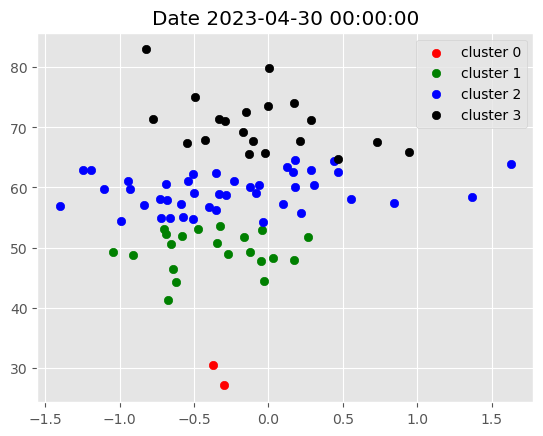

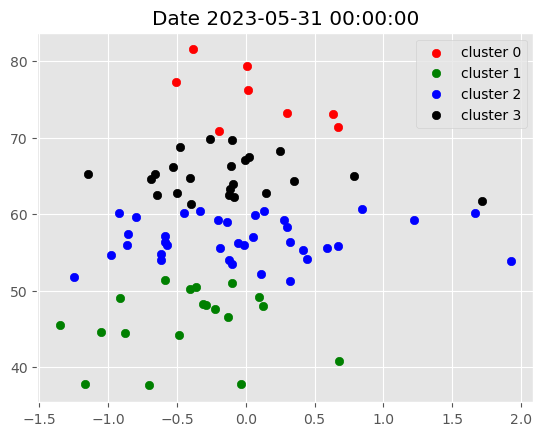

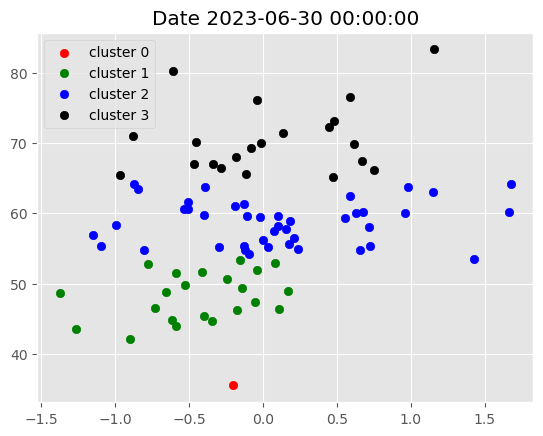

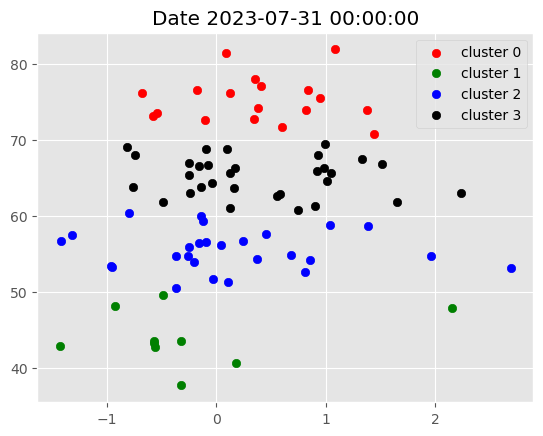

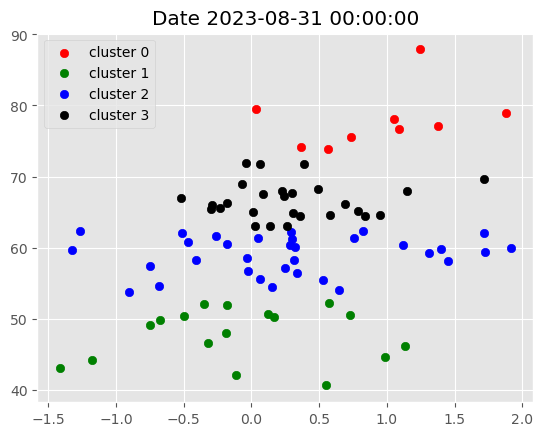

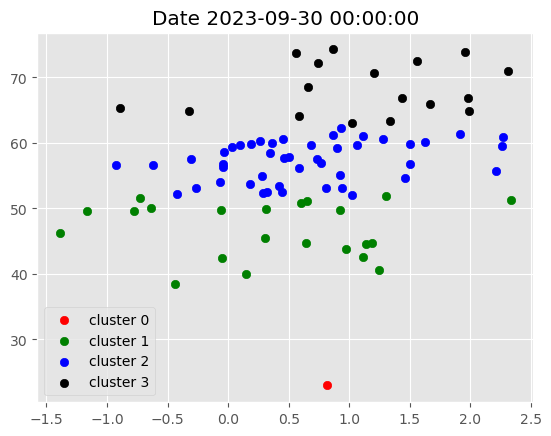

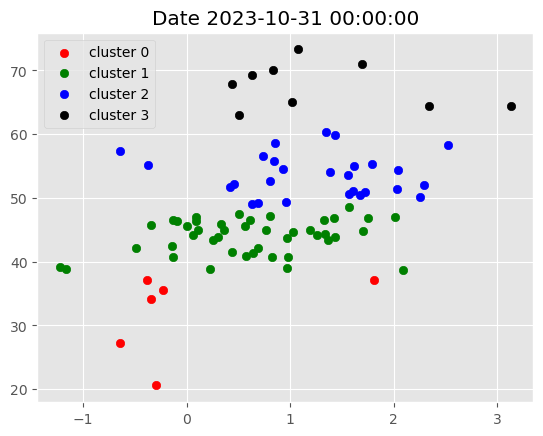

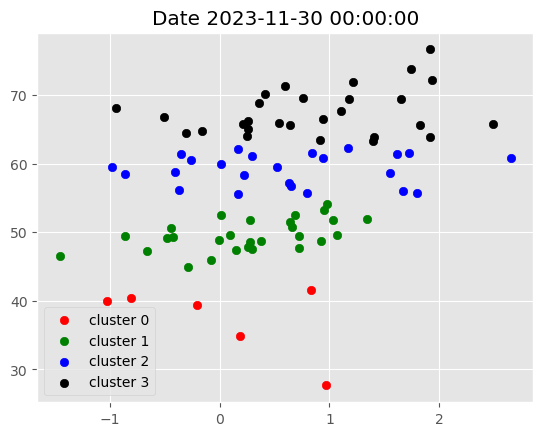

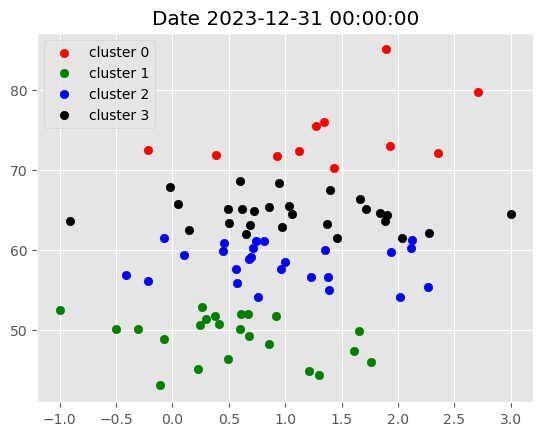

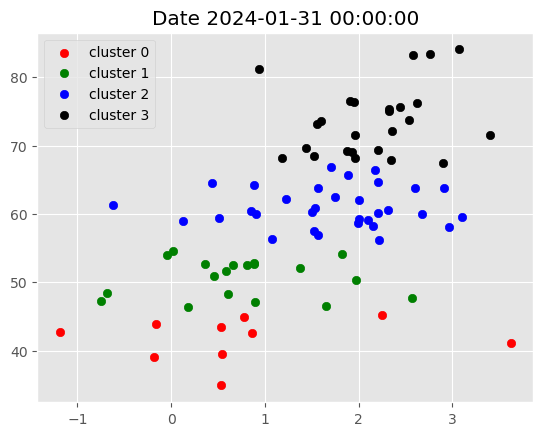

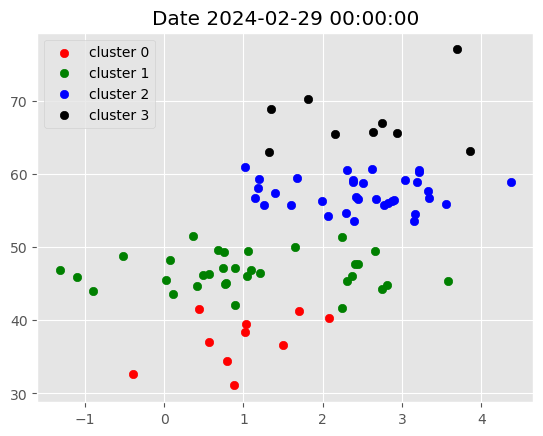

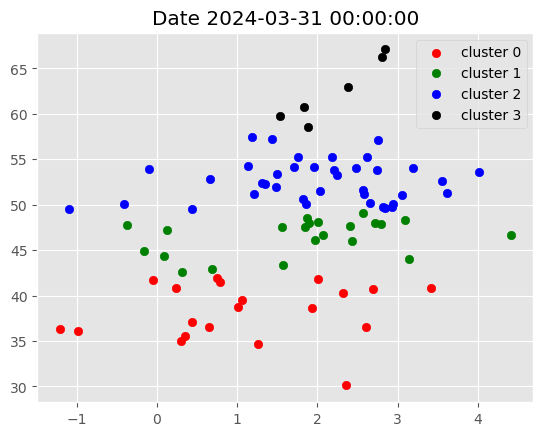

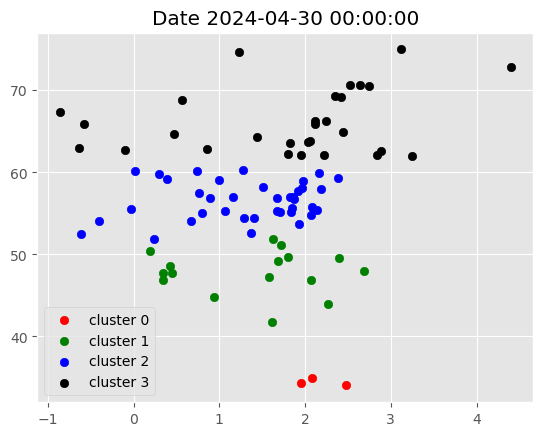

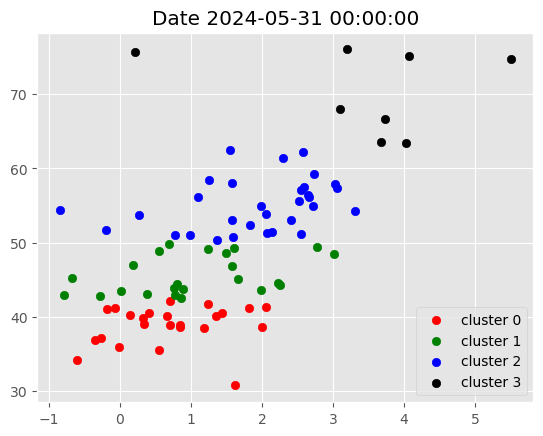

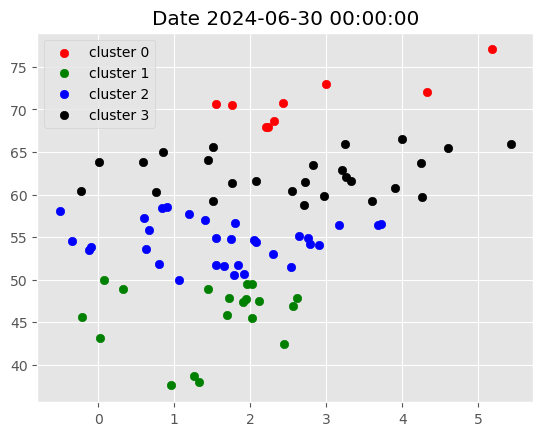

In [23]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [20]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## Portfolio

In [24]:
portfolioRSI = data[data['cluster']==3]
portfolioRSI

atr   bb_high    bb_low    bb_mid  \
date       ticker                                                  
2021-01-31 CEATLTD.NS     1.206617  7.345626  6.908110  7.126868   
           CROMPTON.NS    3.487787  6.043910  5.859105  5.951507   
           CYIENT.NS      0.294146  6.363259  6.036793  6.200026   
           IEX.NS        -0.332637  4.389115  4.223372  4.306243   
           IIFL.NS       -1.295406  4.845017  4.626726  4.735872   
...                            ...       ...       ...       ...   
2024-06-30 RKFORGE.NS     3.240626  6.898288  6.417158  6.657723   
           TEJASNET.NS    3.992960  7.372292  6.988942  7.180617   
           TRITURBINE.NS  2.544095  6.438913  6.288160  6.363536   
           WELSPUNLIV.NS  0.755004  5.054916  4.865016  4.959966   
           AFFLE.NS       1.438798  7.242509  6.994187  7.118348   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2021-01-31 CEATLTD.NS             0.000655  2.211212  70.904583   0.359669   
           CROMPTON.NS            0.000973  2.440974  65.818939   0.124031   
           CYIENT.NS             -0.002332  0.653478  62.768378   0.180392   
           IEX.NS                -0.000864  0.423895  64.249500   0.091752   
           IIFL.NS                0.008332  0.254100  77.655836   0.290989   
...                                    ...       ...        ...        ...   
2024-06-30 RKFORGE.NS             0.000158  5.144170  65.962266   0.336035   
           TEJASNET.NS            0.000447  3.890660  66.528179   0.268037   
           TRITURBINE.NS          0.000316  1.575661  60.408138   0.056710   
           WELSPUNLIV.NS          0.000264  0.630352  60.254214   0.127730   
           AFFLE.NS               0.000472  1.625558  64.031130   0.181534   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2021-01-31 CEATLTD.NS      0.131760   0.104014   0.091687   0.069411   
           CROMPTON.NS     0.183673   0.130300   0.095987   0.075316   
           CYIENT.NS       0.112684   0.153771   0.106484   0.114461   
           IEX.NS          0.069067   0.091569   0.056222   0.057918   
           IIFL.NS         0.210607   0.252432   0.138735   0.074137   
...                             ...        ...        ...        ...   
2024-06-30 RKFORGE.NS      0.089485   0.088420   0.034851   0.037001   
           TEJASNET.NS     0.111238   0.291224   0.084261   0.054654   
           TRITURBINE.NS   0.074389   0.049551   0.065847   0.039606   
           WELSPUNLIV.NS   0.012813   0.037721   0.010471   0.026561   
           AFFLE.NS        0.095323   0.088562   0.004741   0.021774   

                          return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                              
2021-01-31 CEATLTD.NS       0.033680  0.418168  0.354393 -0.055304  0.352711   
           CROMPTON.NS      0.035476  0.001715  0.061163  0.677798  0.041833   
           CYIENT.NS        0.020532  0.735477 -0.220178 -0.671322 -0.131736   
           IEX.NS           0.036517  0.659868 -0.698699  0.105029 -0.557692   
           IIFL.NS         -0.009163  0.288228  0.134011  0.102594  0.727851   
...                              ...       ...       ...       ...       ...   
2024-06-30 RKFORGE.NS       0.059795  0.556623 -0.936239 -0.555563 -1.550450   
           TEJASNET.NS      0.057287 -0.920771  0.532451 -0.168792 -0.517033   
           TRITURBINE.NS    0.036009  0.667813 -0.181676 -0.266206 -1.650597   
           WELSPUNLIV.NS    0.043309 -0.162711 -1.397188  0.455217  0.013589   
           AFFLE.NS         0.017102  0.036511  0.735018  0.118291 -0.502605   

                               CMA  cluster  
date       ticker                            
2021-01-31 CEATLTD.NS    -0.724036        3  
           CROM

In [25]:
portfolioRSI = portfolioRSI.reset_index(level=1)

In [26]:
portfolioRSI

,ticker,atr,bb_high,bb_low,bb_mid,garman_klass_vol,macd,rsi,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster
date,,,,,,,,,,,,,,,,,,,,
2021-01-31,CEATLTD.NS,1.206617,7.345626,6.908110,7.126868,0.000655,2.211212,70.904583,0.359669,0.131760,0.104014,0.091687,0.069411,0.033680,0.418168,0.354393,-0.055304,0.352711,-0.724036,3
2021-01-31,CROMPTON.NS,3.487787,6.043910,5.859105,5.951507,0.000973,2.440974,65.818939,0.124031,0.183673,0.130300,0.095987,0.075316,0.035476,0.001715,0.061163,0.677798,0.041833,-1.581396,3
2021-01-31,CYIENT.NS,0.294146,6.363259,6.036793,6.200026,-0.002332,0.653478,62.768378,0.180392,0.112684,0.153771,0.106484,0.114461,0.020532,0.735477,-0.220178,-0.671322,-0.131736,0.117211,3
2021-01-31,IEX.NS,-0.332637,4.389115,4.223372,4.306243,-0.000864,0.423895,64.249500,0.091752,0.069067,0.091569,0.056222,0.057918,0.036517,0.659868,-0.698699,0.105029,-0.557692,0.365059,3
2021-01-31,IIFL.NS,-1.295406,4.845017,4.626726,4.735872,0.008332,0.254100,77.655836,0.290989,0.210607,0.252432,0.138735,0.074137,-0.009163,0.288228,0.134011,0.102594,0.727851,0.185944,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,RKFORGE.NS,3.240626,6.898288,6.417158,6.657723,0.000158,5.144170,65.962266,0.336035,0.089485,0.088420,0.034851,0.037001,0.059795,0.556623,-0.936239,-0.555563,-1.550450,0.936950,3
2024-06-30,TEJASNET.NS,3.992960,7.372292,6.988942,7.180617,0.000447,3.890660,66.528179,0.268037,0.111238,0.291224,0.084261,0.054654,0.057287,-0.920771,0.532451,-0.168792,-0.517033,0.255551,3
2024-06-30,TRITURBINE.NS,2.544095,6.438913,6.288160,6.363536,0.000316,1.575661,60.408138,0.056710,0.074389,0.049551,0.065847,0.039606,0.036009,0.667813,-0.181676,-0.266206,-1.650597,0.640850,3


In [27]:
portfolioRSI.index = portfolioRSI.index+pd.DateOffset(1)

In [28]:
portfolioRSI

,ticker,atr,bb_high,bb_low,bb_mid,garman_klass_vol,macd,rsi,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster
date,,,,,,,,,,,,,,,,,,,,
2021-02-01,CEATLTD.NS,1.206617,7.345626,6.908110,7.126868,0.000655,2.211212,70.904583,0.359669,0.131760,0.104014,0.091687,0.069411,0.033680,0.418168,0.354393,-0.055304,0.352711,-0.724036,3
2021-02-01,CROMPTON.NS,3.487787,6.043910,5.859105,5.951507,0.000973,2.440974,65.818939,0.124031,0.183673,0.130300,0.095987,0.075316,0.035476,0.001715,0.061163,0.677798,0.041833,-1.581396,3
2021-02-01,CYIENT.NS,0.294146,6.363259,6.036793,6.200026,-0.002332,0.653478,62.768378,0.180392,0.112684,0.153771,0.106484,0.114461,0.020532,0.735477,-0.220178,-0.671322,-0.131736,0.117211,3
2021-02-01,IEX.NS,-0.332637,4.389115,4.223372,4.306243,-0.000864,0.423895,64.249500,0.091752,0.069067,0.091569,0.056222,0.057918,0.036517,0.659868,-0.698699,0.105029,-0.557692,0.365059,3
2021-02-01,IIFL.NS,-1.295406,4.845017,4.626726,4.735872,0.008332,0.254100,77.655836,0.290989,0.210607,0.252432,0.138735,0.074137,-0.009163,0.288228,0.134011,0.102594,0.727851,0.185944,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,RKFORGE.NS,3.240626,6.898288,6.417158,6.657723,0.000158,5.144170,65.962266,0.336035,0.089485,0.088420,0.034851,0.037001,0.059795,0.556623,-0.936239,-0.555563,-1.550450,0.936950,3
2024-07-01,TEJASNET.NS,3.992960,7.372292,6.988942,7.180617,0.000447,3.890660,66.528179,0.268037,0.111238,0.291224,0.084261,0.054654,0.057287,-0.920771,0.532451,-0.168792,-0.517033,0.255551,3
2024-07-01,TRITURBINE.NS,2.544095,6.438913,6.288160,6.363536,0.000316,1.575661,60.408138,0.056710,0.074389,0.049551,0.065847,0.039606,0.036009,0.667813,-0.181676,-0.266206,-1.650597,0.640850,3


In [29]:
portfolioRSI = portfolioRSI.reset_index().set_index(['date', 'ticker'])
portfolioRSI

atr   bb_high    bb_low    bb_mid  \
date       ticker                                                  
2021-02-01 CEATLTD.NS     1.206617  7.345626  6.908110  7.126868   
           CROMPTON.NS    3.487787  6.043910  5.859105  5.951507   
           CYIENT.NS      0.294146  6.363259  6.036793  6.200026   
           IEX.NS        -0.332637  4.389115  4.223372  4.306243   
           IIFL.NS       -1.295406  4.845017  4.626726  4.735872   
...                            ...       ...       ...       ...   
2024-07-01 RKFORGE.NS     3.240626  6.898288  6.417158  6.657723   
           TEJASNET.NS    3.992960  7.372292  6.988942  7.180617   
           TRITURBINE.NS  2.544095  6.438913  6.288160  6.363536   
           WELSPUNLIV.NS  0.755004  5.054916  4.865016  4.959966   
           AFFLE.NS       1.438798  7.242509  6.994187  7.118348   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2021-02-01 CEATLTD.NS             0.000655  2.211212  70.904583   0.359669   
           CROMPTON.NS            0.000973  2.440974  65.818939   0.124031   
           CYIENT.NS             -0.002332  0.653478  62.768378   0.180392   
           IEX.NS                -0.000864  0.423895  64.249500   0.091752   
           IIFL.NS                0.008332  0.254100  77.655836   0.290989   
...                                    ...       ...        ...        ...   
2024-07-01 RKFORGE.NS             0.000158  5.144170  65.962266   0.336035   
           TEJASNET.NS            0.000447  3.890660  66.528179   0.268037   
           TRITURBINE.NS          0.000316  1.575661  60.408138   0.056710   
           WELSPUNLIV.NS          0.000264  0.630352  60.254214   0.127730   
           AFFLE.NS               0.000472  1.625558  64.031130   0.181534   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2021-02-01 CEATLTD.NS      0.131760   0.104014   0.091687   0.069411   
           CROMPTON.NS     0.183673   0.130300   0.095987   0.075316   
           CYIENT.NS       0.112684   0.153771   0.106484   0.114461   
           IEX.NS          0.069067   0.091569   0.056222   0.057918   
           IIFL.NS         0.210607   0.252432   0.138735   0.074137   
...                             ...        ...        ...        ...   
2024-07-01 RKFORGE.NS      0.089485   0.088420   0.034851   0.037001   
           TEJASNET.NS     0.111238   0.291224   0.084261   0.054654   
           TRITURBINE.NS   0.074389   0.049551   0.065847   0.039606   
           WELSPUNLIV.NS   0.012813   0.037721   0.010471   0.026561   
           AFFLE.NS        0.095323   0.088562   0.004741   0.021774   

                          return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                              
2021-02-01 CEATLTD.NS       0.033680  0.418168  0.354393 -0.055304  0.352711   
           CROMPTON.NS      0.035476  0.001715  0.061163  0.677798  0.041833   
           CYIENT.NS        0.020532  0.735477 -0.220178 -0.671322 -0.131736   
           IEX.NS           0.036517  0.659868 -0.698699  0.105029 -0.557692   
           IIFL.NS         -0.009163  0.288228  0.134011  0.102594  0.727851   
...                              ...       ...       ...       ...       ...   
2024-07-01 RKFORGE.NS       0.059795  0.556623 -0.936239 -0.555563 -1.550450   
           TEJASNET.NS      0.057287 -0.920771  0.532451 -0.168792 -0.517033   
           TRITURBINE.NS    0.036009  0.667813 -0.181676 -0.266206 -1.650597   
           WELSPUNLIV.NS    0.043309 -0.162711 -1.397188  0.455217  0.013589   
           AFFLE.NS         0.017102  0.036511  0.735018  0.118291 -0.502605   

                               CMA  cluster  
date       ticker                            
2021-02-01 CEATLTD.NS    -0.724036        3  
           CROM

In [30]:
dates = portfolioRSI.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = portfolioRSI.xs(d, level=0).index.tolist()
    
fixed_dates

{'2021-02-01': ['CEATLTD.NS',
  'CROMPTON.NS',
  'CYIENT.NS',
  'IEX.NS',
  'IIFL.NS',
  'JBMA.NS',
  'OLECTRA.NS',
  'TRIDENT.NS',
  'TTML.NS'],
 '2021-03-01': ['AAVAS.NS',
  'AMBER.NS',
  'APARINDS.NS',
  'BLUESTARCO.NS',
  'CDSL.NS',
  'GESHIP.NS',
  'GNFC.NS',
  'GRAPHITE.NS',
  'GSPL.NS',
  'HINDCOPPER.NS',
  'HUDCO.NS',
  'IDFC.NS',
  'IEX.NS',
  'IIFL.NS',
  'IOB.NS',
  'JBMA.NS',
  'KARURVYSYA.NS',
  'KEC.NS',
  'NATIONALUM.NS',
  'NBCC.NS',
  'NCC.NS',
  'OLECTRA.NS',
  'PNBHOUSING.NS',
  'PRAJIND.NS',
  'RADICO.NS',
  'RAYMOND.NS',
  'REDINGTON.NS',
  'SONATSOFTW.NS',
  'TANLA.NS',
  'TEJASNET.NS',
  'ZENSARTECH.NS'],
 '2021-04-01': ['AAVAS.NS',
  'APARINDS.NS',
  'BLUESTARCO.NS',
  'CANFINHOME.NS',
  'CDSL.NS',
  'FSL.NS',
  'GRAPHITE.NS',
  'GSPL.NS',
  'INTELLECT.NS',
  'JBCHEPHARM.NS',
  'OLECTRA.NS',
  'PRAJIND.NS',
  'SONATSOFTW.NS'],
 '2021-05-01': ['CYIENT.NS',
  'GLENMARK.NS',
  'HINDCOPPER.NS',
  'IDFC.NS',
  'IEX.NS',
  'MRPL.NS',
  'NATIONALUM.NS',
  'PRAJIND.NS',

## Portfolio Optimisation

In [31]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [32]:
def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [33]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  86 of 86 completed

2 Failed downloads:
['HINDCOPPER.NS', 'EXIDEIND.NS']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


Price        Adj Close                                                     \
Ticker     AARTIIND.NS     AAVAS.NS     AFFLE.NS ALOKINDS.NS     AMBER.NS   
Date                                                                        
2020-01-31  484.421661  1994.050049   330.329987    3.300000  1508.333130   
2020-02-03  476.529114  1988.800049   350.880005    3.300000  1532.149780   
2020-02-04  473.677002  1970.599976   359.339996    3.300000  1601.003052   
2020-02-05  484.888855  1950.849976   353.859985    3.300000  1576.287720   
2020-02-06  472.496796  1954.150024   339.070007    3.300000  1567.150513   
...                ...          ...          ...         ...          ...   
2024-06-24  704.928223  1879.400024  1316.800049   28.320000  4108.899902   
2024-06-25  694.193787  1855.150024  1290.099976   27.959999  4051.550049   
2024-06-26  693.544739  1869.500000  1370.550049   28.639999  4262.750000   
2024-06-27  686.205383  1872.500000  1333.949951   27.799999  4279.250000   
2024-06-28  685.256714  1853.099976  1343.699951   27.920000  4521.750000   

Price                                                                        \
Ticker      APARINDS.NS      BLS.NS BLUESTARCO.NS    BSOFT.NS CANFINHOME.NS   
Date                                                                          
2020-01-31   365.391235   15.738358    402.429779   74.301331    468.697998   
2020-02-03   362.948700   15.915993    385.177673   83.665070    472.280579   
2020-02-04   363.324432   16.271265    384.722382   82.354141    468.407440   
2020-02-05   368.444366   16.176523    391.239868   83.711891    463.953308   
2020-02-06   375.771912   16.721266    387.142456   87.129662    474.749664   
...                 ...         ...           ...         ...           ...   
2024-06-24  8470.700195  353.200012   1686.857178  681.311768    878.672729   
2024-06-25  8509.250000  352.350006   1667.537231  691.751404    895.546326   
2024-06-26  8398.299805  363.500000   1645.478760  681.709473    897.188904   
2024-06-27  8475.950195  359.750000   1633.876831  682.952332    906.745667   
2024-06-28  8473.450195  350.600006   1627.802124  686.332764    911.076050   

Price       ...        Volume                                     \
Ticker      ... TATAINVEST.NS TEJASNET.NS TITAGARH.NS TRIDENT.NS   
Date        ...                                                    
2020-01-31  ...         35592       30159     1543972    7408753   
2020-02-03  ...         16000      173715     1256799    4455231   
2020-02-04  ...         32698       90536      563567    5496067   
2020-02-05  ...        100498       50784      647694    5210085   
2020-02-06  ...        160150      168025      402956    6460496   
...         ...           ...         ...         ...        ...   
2024-06-24  ...         83990      550055     3835873    6828138   
2024-06-25  ...         23631      553562     1798998    5663109   
2024-06-26  ...         29198      419607     7403061   10827065   
2024-06-27  ...         32597     2011442    10045103    7769670   
2024-06-28  ...         44951      502007     3369065    6728587   

Price                                                                      \
Ticker     TRITURBINE.NS   TTML.NS UCOBANK.NS UJJIVANSFB.NS WELSPUNLIV.NS   
Date                                                                        
2020-01-31         20876    359869     370772       3129732        671561   
2020-02-03         63649    759821     465146       1987363        351555   
2020-02-04         25405   3558586     395506       2223160       1037724   
2020-02-05         17807   3458761     435534       6277829        862950   
2020-02-06         39105   1088213    3805669       4033152        409460   
...                  ...       ...        ...           ...           ...   
2024-06-24       1193497   2719696    6734795      83961391       2792763   
2024-06-25        727250   2791076    7446858      28339037       1172183   
2024-06-26    

### Calculating daily returns for our stocks

In [34]:
returns_df = np.log(new_df['Adj Close']).diff()
returns_df

Ticker,AARTIIND.NS,AAVAS.NS,AFFLE.NS,ALOKINDS.NS,AMBER.NS,APARINDS.NS,BLS.NS,BLUESTARCO.NS,BSOFT.NS,CANFINHOME.NS,...,TATAINVEST.NS,TEJASNET.NS,TITAGARH.NS,TRIDENT.NS,TRITURBINE.NS,TTML.NS,UCOBANK.NS,UJJIVANSFB.NS,WELSPUNLIV.NS,ZENSARTECH.NS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,-0.016427,-0.002636,0.060352,0.000000,0.015667,-0.006707,0.011224,-0.043816,0.118693,0.007615,...,-0.020316,-0.080710,-0.163372,-0.008032,0.015693,-0.042560,-0.049433,-0.046776,-0.030663,-0.038707
2020-02-04,-0.006003,-0.009193,0.023825,0.000000,0.043959,0.001035,0.022076,-0.001183,-0.015793,-0.008235,...,-0.004603,0.023732,0.035758,-0.008097,-0.031117,0.178692,0.006734,0.014912,0.015449,-0.002432
2020-02-05,0.023394,-0.010073,-0.015368,0.000000,-0.015558,0.013994,-0.005840,0.016799,0.016352,-0.009555,...,0.030128,0.006494,-0.016602,-0.024693,-0.013563,0.000000,0.013334,0.039896,0.017534,-0.008251
2020-02-06,-0.025889,0.001690,-0.042695,0.000000,-0.005814,0.019693,0.033120,-0.010528,0.040016,0.023004,...,0.030534,0.024929,-0.014615,-0.008368,-0.010029,-0.075508,0.051624,0.008850,-0.001159,0.016535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,-0.003323,-0.018608,0.041675,0.003183,0.035019,0.014939,-0.021566,0.003519,0.005708,0.025008,...,0.021459,0.003281,0.016978,-0.001815,-0.021421,-0.013988,-0.009739,-0.053734,0.010122,0.001926
2024-06-25,-0.015345,-0.012987,-0.020485,-0.012793,-0.014056,0.004541,-0.002409,-0.011519,0.015207,0.019021,...,-0.009996,-0.005616,0.005174,-0.006769,0.017994,0.000517,-0.010734,-0.013178,-0.005841,-0.002924
2024-06-26,-0.000935,0.007705,0.060492,0.024029,0.050815,-0.013125,0.031154,-0.013316,-0.014623,0.001832,...,-0.011516,-0.012260,0.086300,0.010654,0.033751,0.041617,-0.008671,-0.030074,0.036961,-0.000067


In [35]:
portfolio_df = pd.DataFrame()

In [36]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights

,Strategy Return
date,
2021-02-01,0.032018
2021-02-02,0.033581
2021-02-03,0.025328
2021-02-04,0.021234
2021-02-05,0.003077
...,...
2024-06-24,0.004253
2024-06-25,0.003117
2024-06-26,0.012996


#Portfolio comparison with Nifty

In [37]:
nifty = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nifty_ret = np.log(nifty[['Adj Close']]).diff().dropna().rename({'Adj Close':'NIFTY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nifty_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,NIFTY Buy&Hold
2021-02-01,0.032018,0.046333
2021-02-02,0.033581,0.025350
2021-02-03,0.025328,0.009654
2021-02-04,0.021234,0.007121
2021-02-05,0.003077,0.001918
...,...,...
2024-06-24,0.004253,0.001563
2024-06-25,0.003117,0.007764
2024-06-26,0.012996,0.006199
2024-06-27,-0.002450,0.007334


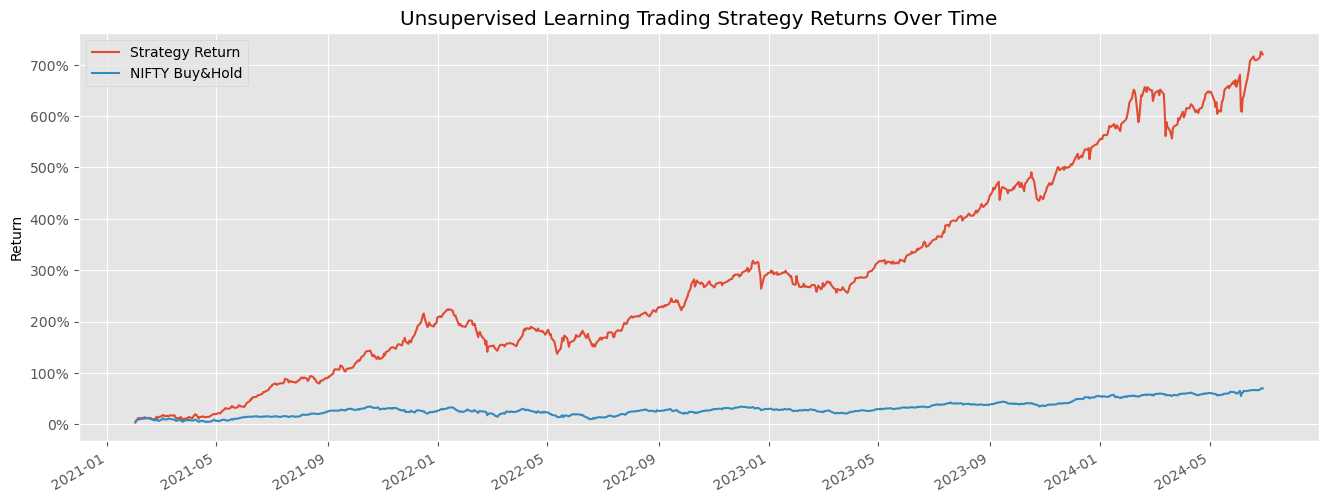

In [38]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-06-28'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [40]:
portfolio_cumulative_ret = np.exp(np.log1p(portfolio_df).cumsum()) - 1
portfolio_percentage_ret = portfolio_cumulative_return * 100
portfolio_percentage_ret_to_date = portfolio_percentage_ret[:'2024-06-28']
portfolio_percentage_ret_to_date

,Strategy Return,NIFTY Buy&Hold
2021-02-01,3.201760,4.633335
2021-02-02,6.667337,7.285742
2021-02-03,9.368994,8.321518
2021-02-04,11.691332,9.092912
2021-02-05,12.034986,9.302170
...,...,...
2024-06-24,712.485435,66.443335
2024-06-25,715.017794,67.735546
2024-06-26,725.609477,68.775303
2024-06-27,723.586339,70.013114
